# MMAI 891 - TOPIC ANALYSIS based on Exercise 3
## Transfer learning with DistilBert
The goal of this excercise is to build a topic analyzer using the pretrained DistilBert published by HuggingFace. The dataset is from CodaLab, copied local to Google Drive



In [ ]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install keras_tuner

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds
import keras_tuner as kt

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# My additions
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 4.5 MB 42.9 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.2 MB/s 


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
# 891 specific additions
from google.colab import drive
drive.mount('/content/drive')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns

Mounted at /content/drive


In [ ]:
pd.set_option("display.max_columns", 200)

In [ ]:
# Load training data
df = pd.read_csv("/content/drive/My Drive/public_data.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17999 entries, 0 to 17998
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       17999 non-null  int64 
 1   message  17999 non-null  object
 2   label    17999 non-null  object
dtypes: int64(1), object(2)
memory usage: 422.0+ KB
None
      id                                            message           label
0   1285                            i can't find my luggage    lost_luggage
1   7663                         what's my name saved under       user_name
2  20641  send me an uber now for four people and we are...            uber
3  16445                alter back to your orginal settings  reset_settings
4    317                     i want today's fun fact please        fun_fact


In [ ]:
### Number of unique labels
print("Number of unique values in each DF column:")
print(df.nunique())

Number of unique values in each DF column:
id         17999
message    17995
label        150
dtype: int64


In [ ]:
print(df.shape)
df.head(2)

(17999, 3)


,id,message,label
0,1285,i can't find my luggage,lost_luggage
1,7663,what's my name saved under,user_name


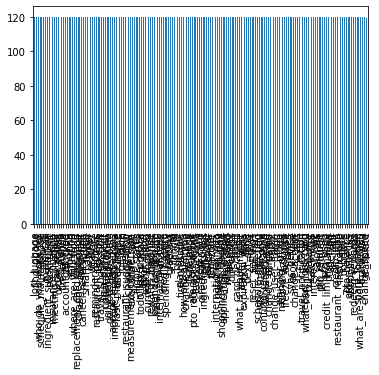

In [ ]:
# plot number of occurrences of each unique label
df['label'].value_counts(sort=True).plot.bar()

# DATA PREPARATION

In [ ]:
# TBD

# Train/Validation SPLIT, PIPELINE 

In [ ]:
# Data / Label split
#df_X_train['Sentence'] = df_X_train['Sentence'].str.lower()
# ORIGINAL X = df['message']
X = df['message'].str.lower()
y = df['label']

# ONE HOT ENCODE FOR TRANSFORMER (before train/test split)


In [ ]:
# From this website:
# https://towardsdatascience.com/how-to-assign-labels-with-sklearn-one-hot-encoder-e59a5f17df4f

from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                #new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                new_columns.append(f'{self.categories_[i][j]}')
                j += 1
        return new_columns

In [ ]:
def ohe (labels):
  encoder = OneHotEncoder(handle_unknown='ignore')

  df = pd.DataFrame(labels)
  encoder_df = pd.DataFrame(encoder.fit_transform(df))

  return encoder_df


In [ ]:
y = ohe(y)

In [ ]:
y.head()

,accept_reservations,account_blocked,alarm,application_status,apr,are_you_a_bot,balance,bill_balance,bill_due,book_flight,book_hotel,calculator,calendar,calendar_update,calories,cancel,cancel_reservation,car_rental,card_declined,carry_on,change_accent,change_ai_name,change_language,change_speed,change_user_name,change_volume,confirm_reservation,cook_time,credit_limit,credit_limit_change,credit_score,current_location,damaged_card,date,definition,direct_deposit,directions,distance,do_you_have_pets,exchange_rate,expiration_date,find_phone,flight_status,flip_coin,food_last,freeze_account,fun_fact,gas,gas_type,goodbye,greeting,how_busy,how_old_are_you,improve_credit_score,income,ingredient_substitution,ingredients_list,insurance,insurance_change,interest_rate,international_fees,international_visa,jump_start,last_maintenance,lost_luggage,make_call,maybe,meal_suggestion,meaning_of_life,measurement_conversion,meeting_schedule,min_payment,mpg,new_card,next_holiday,next_song,no,nutrition_info,oil_change_how,oil_change_when,order,order_checks,order_status,pay_bill,payday,pin_change,play_music,plug_type,pto_balance,pto_request,pto_request_status,pto_used,recipe,redeem_rewards,reminder,reminder_update,repeat,replacement_card_duration,report_fraud,report_lost_card,reset_settings,restaurant_reservation,restaurant_reviews,restaurant_suggestion,rewards_balance,roll_dice,rollover_401k,routing,schedule_maintenance,schedule_meeting,share_location,shopping_list,shopping_list_update,smart_home,spelling,spending_history,sync_device,taxes,tell_joke,text,thank_you,time,timer,timezone,tire_change,tire_pressure,todo_list,todo_list_update,traffic,transactions,transfer,translate,travel_alert,travel_notification,travel_suggestion,uber,update_playlist,user_name,vaccines,w2,weather,what_are_your_hobbies,what_can_i_ask_you,what_is_your_name,what_song,where_are_you_from,whisper_mode,who_do_you_work_for,who_made_you,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# want to save off 1/2 the validation data for prediction inference
#X_val, X_val2, y_val, y_val2 = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
#print(X_val2.shape)
#print(y_val2.shape)

(12599,)
(12599, 150)
(5400,)
(5400, 150)


In [ ]:
#vectorizer = CountVectorizer(min_df=.01, max_df=.8, ngram_range=[1,1], max_features=300, stop_words='english')
#
#pipe = Pipeline([('vec', vectorizer),  ('clf', DecisionTreeClassifier(random_state=223))])
#
#pipe.fit(X_train, y_train)

In [ ]:
#from sklearn.metrics import confusion_matrix, classification_report
#
#pred_val = pipe.predict(X_val)
#print(confusion_matrix(y_val, pred_val))
#print(classification_report(y_val, pred_val))

In [ ]:
#from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
#
#ari = adjusted_rand_score(y_val, pred_val)
#ami = adjusted_mutual_info_score(y_val, pred_val, average_method='arithmetic')
#
#print("ARI: {}".format(ari))
#print("AMI: {}".format(ami))

# TEST DATA LOAD, PIPELINE and SUBMISSION



In [ ]:
# Load test data
df_test = pd.read_csv("/content/drive/My Drive/input_data.csv")
df_test.info()
df_test['message'] = df_test['message'].str.lower()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       4500 non-null   int64 
 1   message  4500 non-null   object
dtypes: int64(1), object(1)
memory usage: 70.4+ KB


,id,message
0,421,is it after noon
1,11972,go ahead and say all of the points on my list ...
2,345,is it possible to talk to you in mandarin
3,1383,that's true
4,6905,can i make a reservation for 6 pm on the 21st ...


In [ ]:
# Run the pipeline
#pred_test = pipe.predict(df_test['message'])

In [ ]:
# Package predictions as dataframe
#my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
#print(my_submission.head())

In [ ]:
# NOTE: after saving the CSV file, be sure to zip the file before submitting to the competition website!
#my_submission.to_csv('answers.csv', index=False)

# TRANSFORMER STUFF

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
#print(f'X_val2 shape: {X_val2.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
#print(f'y_val2 shape: {y_val2.shape}')

X_train shape: (12599,)
X_val shape: (5400,)
y_train shape: (12599, 150)
y_val shape: (5400, 150)


In [ ]:
# XXX Come back later and go from Series to list. Skip the dataframe step
df_X_train = X_train.to_frame()
df_X_val   = X_val.to_frame()
#df_X_val2  = X_val2.to_frame()

#print(f'y_train, y_val and y_val2 are already DataFrames:\n{type(y_train), type(y_val), type(y_val2)}')
#df_y_train = y_train.to_frame()
#df_y_val   = y_val.to_frame()
#df_y_val2  = y_val2.to_frame()
df_y_train = y_train
df_y_val   = y_val
#df_y_val2  = y_val2


In [ ]:
df_y_train.head(2)

,accept_reservations,account_blocked,alarm,application_status,apr,are_you_a_bot,balance,bill_balance,bill_due,book_flight,book_hotel,calculator,calendar,calendar_update,calories,cancel,cancel_reservation,car_rental,card_declined,carry_on,change_accent,change_ai_name,change_language,change_speed,change_user_name,change_volume,confirm_reservation,cook_time,credit_limit,credit_limit_change,credit_score,current_location,damaged_card,date,definition,direct_deposit,directions,distance,do_you_have_pets,exchange_rate,expiration_date,find_phone,flight_status,flip_coin,food_last,freeze_account,fun_fact,gas,gas_type,goodbye,greeting,how_busy,how_old_are_you,improve_credit_score,income,ingredient_substitution,ingredients_list,insurance,insurance_change,interest_rate,international_fees,international_visa,jump_start,last_maintenance,lost_luggage,make_call,maybe,meal_suggestion,meaning_of_life,measurement_conversion,meeting_schedule,min_payment,mpg,new_card,next_holiday,next_song,no,nutrition_info,oil_change_how,oil_change_when,order,order_checks,order_status,pay_bill,payday,pin_change,play_music,plug_type,pto_balance,pto_request,pto_request_status,pto_used,recipe,redeem_rewards,reminder,reminder_update,repeat,replacement_card_duration,report_fraud,report_lost_card,reset_settings,restaurant_reservation,restaurant_reviews,restaurant_suggestion,rewards_balance,roll_dice,rollover_401k,routing,schedule_maintenance,schedule_meeting,share_location,shopping_list,shopping_list_update,smart_home,spelling,spending_history,sync_device,taxes,tell_joke,text,thank_you,time,timer,timezone,tire_change,tire_pressure,todo_list,todo_list_update,traffic,transactions,transfer,translate,travel_alert,travel_notification,travel_suggestion,uber,update_playlist,user_name,vaccines,w2,weather,what_are_your_hobbies,what_can_i_ask_you,what_is_your_name,what_song,where_are_you_from,whisper_mode,who_do_you_work_for,who_made_you,yes
8213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#labels = df['label'].unique()
#print(labels)

Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [ ]:
def make_y_a_numpy_array(df):
  # Initially thoughts I needed lists, but this is simple df to numpy
  y = df.to_numpy()
  return y


def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    batch_size = 128
    input_ids = []
    attention_mask = []

    temp = text['message'].to_list()
    for count in range(0, len(text), batch_size):
      batch_text = temp[count:count+batch_size]
      # have to truncate b/c was resulting in a non-rectangular shape
      output = dbert_tokenizer(batch_text,
                             padding='max_length',
                             return_attention_mask=True,
                             # REDUCED from 256 -> 128 to avoid GPU overload 07Apr22
                             max_length=96, #128, #256, #96  # was 512, but took waay too long
                             truncation=True
                             )
      input_ids.extend(output['input_ids'])
      attention_mask.extend(output['attention_mask'])

    # Try switching everything to numpy arrays
    input_ids = np.array(input_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
np_array_y_train = make_y_a_numpy_array(df_y_train)
np_array_y_val   = make_y_a_numpy_array(df_y_val)
#np_array_y_val2  = make_y_a_numpy_array(df_y_val2)


train_input, train_mask = encode_text(df_X_train)
val_input, val_mask = encode_text(df_X_val)
#val_input2, val_mask2 = encode_text(df_X_val2)
test_input, test_mask = encode_text(df_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

#val_model_inputs_and_masks2 = {
#    'inputs' : val_input2,
#    'masks' : val_mask2
#}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

# Modelling

## Build and Train Model

Resources:
- BERT paper https://arxiv.org/pdf/1810.04805.pdf
- DistilBert paper: https://arxiv.org/abs/1910.01108
- DistilBert Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        # TODO: build the model, with the option to freeze the parameters in distilBERT
        # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
        # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
        # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
        # Hint 3: double check that your number of parameters make sense
        # Hint 4: carefully consider your final layer activation and loss function

        # Refer to https://keras.io/api/layers/core_layers/input/
        base_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        trainable=True

        params= {
          "max_seq_len":256,
          "layer_dropout":0.25,
          "random_seed": 91 # 53 # 91
          }

        max_seq_len = params['max_seq_len']
        layer_dropout = params['layer_dropout']
        #random_seed = params['random_seed']
        hp_rand = hp.Choice('random_seed', values=[17, 29, 53, 71, 91, 2])

        initial_weights = keras.initializers.GlorotNormal(seed=hp_rand) #random_seed)

        inputs = Input(shape=(max_seq_len,), 
                      name='input_ids', 
                      dtype='int32')
        masks  = Input(shape=(max_seq_len,), 
                      name='input_attention', 
                      dtype='int32')

        base_model.trainable = trainable

        dbert_output = base_model(inputs, attention_mask=masks)
        # dbert_last_hidden_state gets you the output encoding for each of your tokens.
        # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
        # which can be used to build a sentence classification network
        dbert_last_hidden_state = dbert_output.last_hidden_state


        # Any additional layers should go here
        # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
        cls_token = dbert_last_hidden_state[:, 0, :]
        X = tf.keras.layers.BatchNormalization()(cls_token)

        hp_units_1 = hp.Int('units1', min_value=128, max_value=192, step=16)
        X = tf.keras.layers.Dense(hp_units_1, activation='relu')(X)
        X = tf.keras.layers.Dropout(layer_dropout)(X)

        my_output = X
        probs = Dense(77, 
                      activation='sigmoid',
                      kernel_initializer=initial_weights,  
                      kernel_constraint=None,
                      bias_initializer='zeros'
                      )(my_output)

        model = keras.Model(inputs=[inputs, masks], outputs=probs)
        print(model.summary())

        metrics = [keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.CategoricalAccuracy(), keras.metrics.AUC(),
               #keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32),
               keras.metrics.Precision()]

        #loss = tfa.losses.SigmoidFocalCrossEntropy()
        #loss = keras.losses.BinaryCrossentropy()
        loss = keras.losses.CategoricalCrossentropy()

        #hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4]) ## [1e-3, 1e-4, 1e-5]
        # Following learning rate is for UNFROZEN model
        hp_learning_rate = hp.Choice('learning_rate', values=[5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6])
        model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss=loss,
                  metrics=metrics)

        return model
    def fit(self, hp, model, *args, **kwargs):

        return model.fit(
            *args,
            #batch_size=hp.Choice("batch_size", [32, 128]),
            batch_size=hp.Choice("batch_size", [16, 32, 48, 64, 96, 128]),
            **kwargs)


In [ ]:
tuner = kt.Hyperband(MyHyperModel(),
                     objective='val_categorical_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory="/tmp/tb")
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
import datetime
import os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# log_dir = "/tmp/tb_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/tmp/tb_logs", histogram_freq=1)

In [ ]:
# print the best 50 trials
tuner.results_summary(50)

Results summary
Results in /tmp/tb/untitled_project
Showing 50 best trials


In [ ]:
def build_model(base_model, trainable=True, params={}):
    # TODO: build the model, with the option to freeze the parameters in distilBERT
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
    # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
    # Hint 3: double check that your number of parameters make sense
    # Hint 4: carefully consider your final layer activation and loss function

    # Refer to https://keras.io/api/layers/core_layers/input/
    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

    inputs = Input(shape=(max_seq_len,), 
                   name='input_ids', 
                   dtype='int32')
    masks  = Input(shape=(max_seq_len,), 
                   name='input_attention', 
                   dtype='int32')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    # dbert_last_hidden_state gets you the output encoding for each of your tokens.
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state


    # Any additional layers should go here
    # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
    cls_token = dbert_last_hidden_state[:, 0, :]
    X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(layer_dropout)(X)

    my_output = X
    probs = Dense(77, #23, #28, 
                  #activation='softmax',
                  activation='sigmoid',
                  kernel_initializer=initial_weights,  
                  kernel_constraint=None,
                  bias_initializer='zeros'
                  )(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params= {
        # MAX_SEQ_LEN: 256 -> 128 to avoid GPU RAM exhaustion - 07Apr22
        "max_seq_len":96, #128, #256,
        "layer_dropout":0.25,
        "learning":5e-4,#0.001,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 96)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 96)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 96, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
from sklearn.metrics import roc_auc_score

def compile_model(model):
    # TODO: compile the model, include relevant auc metrics when training
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    # Metrics
    metrics = [keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.CategoricalAccuracy(), keras.metrics.AUC()]#,
               #keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32),
               #keras.metrics.Precision()]#, label_smoothing=0.5)]

    # Switch to Categorical to support multi-class classification
    loss = keras.losses.CategoricalCrossentropy()
    # Try binary cross-entropy and switch model to sigmoid
    #loss = keras.losses.BinaryCrossentropy()
    # Use a new one from TFA
    #loss = tfa.losses.SigmoidFocalCrossEntropy()

    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), 
                  loss=loss,
                  metrics=metrics)

    return model

model = compile_model(model)

In [ ]:
#DEBUG - check shapes
print(train_model_inputs_and_masks["inputs"].shape,
train_model_inputs_and_masks["masks"].shape,
val_model_inputs_and_masks["inputs"].shape,
val_model_inputs_and_masks["masks"].shape, 
val_model_inputs_and_masks2["inputs"].shape,
val_model_inputs_and_masks2["masks"].shape, 
np_array_y_train.shape,
np_array_y_val.shape,
np_array_y_val2.shape)

NameError: ignored

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"]],
                                         y_val),
                        verbose=2)#,
                        #class_weight=class_weights)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=136, num_epochs=3)

In [ ]:
#test_df = pd.DataFrame()
labels = []
predicts = []
pred_argmax = []
iteration = []

def eval_model(model, inputs_and_masks, label):
    test_df = pd.DataFrame()
    labels.clear()
    predicts.clear()
    pred_argmax.clear()
    iteration.clear()
    test_scores = model.evaluate(x = [inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]],
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)
    
    predictions = model.predict([inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]])
    # GOOD print("past predict call")
    #print(f"Length of [predictions] : {len(predictions)}")
    #print(f"Length of [labels] : {len(labels)}")
    #print(f"Length of [label] : {len(label)}")
    for i in range(len(predictions)):
      labels.append(label[i])
      b = np.zeros_like(predictions[i])
      b[predictions.argmax(1)[i]] = 1
      predicts.append(predictions[i])
      pred_argmax.append(b)
      iteration.append(i)
    
    test_df['Labels'] = labels
    test_df['Predictions'] = predicts
    test_df['Pred-Argmax'] = pred_argmax
    test_df['Iteration'] = iteration
    return test_loss, test_metrics, test_df

#val2_df = pd.DataFrame()

#test_loss, test_metrics, val2_df = eval_model(model, val_model_inputs_and_masks2, np_array_y_val2)
#test_loss, test_metrics, test2_df = eval_model(model, test_model_inputs_and_masks, np.zeros((df_test.shape[0],77), dtype=int))

In [ ]:
val2_df.head(2)

In [ ]:
import sys
#import numpy
np.set_printoptions(threshold=sys.maxsize)

print(test_df['Pred-Argmax'][0])

In [ ]:
y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
#y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)
y_pred = tf.convert_to_tensor(pred_argmax, dtype=tf.float32)

In [ ]:
print(y_true.shape, y_pred.shape)
print(len(y_true.numpy().tolist()),len(y_true.numpy().tolist()[0]))

In [ ]:
from sklearn import metrics

metric3 = tf.keras.metrics.KLDivergence()
metric3.update_state(y_true, y_pred)
print("\nKL Divergence: ", metric3.result().numpy())

metric4 = tf.keras.metrics.Accuracy()
metric4.update_state(y_true, y_pred)
print("\nAccuracy: ", metric4.result().numpy())

metric6 = tfa.metrics.F1Score(num_classes=77, threshold=0.5) # was 28 classes
metric6.update_state(y_true, y_pred)
print("\nF1 Score: ", metric6.result().numpy())

metric7 = tf.keras.metrics.SensitivityAtSpecificity(0.95)
metric7.update_state(y_true, y_pred)
print("\nSensitivity: ", metric7.result().numpy())

metric5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=77) # was 28 classes
metric5.update_state(y_true, y_pred)
#print("\nMulti-label Confusion Matrices: \n", metric5.result().numpy())

print(f"Accuracy score using sklearn library : {metrics.accuracy_score(y_true, y_pred)}")

#print(f"Adjusted-mutual-information (AMI) score using sklearn library : {metrics.cluster.adjusted_mutual_info_score(y_true.numpy().tolist(), y_pred.numpy().tolist())}")

macro_averaged_precision = metrics.precision_score(y_true, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score using sklearn library : {macro_averaged_precision}")

In [ ]:
# Run the real TEST DATA -- the label data is garbage but needs to be there
test2_df = pd.DataFrame()

test_loss, test_metrics, test2_df = eval_model(model, test_model_inputs_and_masks, np.zeros((df_test.shape[0],77), dtype=int))

test2_df.head(2)

In [ ]:
test2_df['Index'] = test2_df['Pred-Argmax'].apply(lambda x: np.argmax(x))
test2_df.head(2)

In [ ]:
import re

new_labels = y.columns.values.tolist()
new_labels2 = []

for j in range(len(new_labels)):
  text = y.columns.values.tolist()[j]
  x = re.sub("label_<", "", text)
  x = re.sub(">", "", x)
  new_labels2.append(x)

label_list = []
for j in range(test2_df.shape[0]):
  label_list.append(new_labels2[test2_df['Index'][j]])

test2_df['Labels2'] = label_list
test2_df.head()

In [ ]:
# Package predictions as dataframe
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': test2_df['Labels2']})
print(my_submission.head())

In [ ]:
my_submission.to_csv('answers.csv', index=False)
!cp answers.csv "/content/drive/My Drive/"
#("/content/drive/My Drive/input_data.csv")